In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.units import UnitsWarning
import warnings
from lsst.rsp import get_tap_service, retrieve_query

import healpy as hp
import math
import gc

In [3]:
warnings.simplefilter("ignore", category=UnitsWarning)
pd.set_option('display.max_rows', 200)

In [4]:
%matplotlib inline

In [5]:
service = get_tap_service()

In [125]:
import time
from IPython.display import Image

import numpy
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service

from astropy.cosmology import FlatLambdaCDM

service = get_tap_service()

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

redshift_min = 0.02
redshift_max = 1.4

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range
print('The minimum and maximum apparent r-band magnitudes '
      'to use in the TAP query are %5.2f and %5.2f mag.' %
      (snia_peak_mr_min, snia_peak_mr_max))


snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_ampl_mr_min = 0
snia_ampl_mr_max = 6.0

snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

snia_duration_min = 50
snia_duration_max = 300

results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMin) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMax, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMax, "
                         "scisql_nanojanskyToAbMag(uPSFluxMax) AS uMagMax, "
                         "scisql_nanojanskyToAbMag(yPSFluxMax) AS yMagMax, "
                         "scisql_nanojanskyToAbMag(zPSFluxMax) AS zMagMax, "


                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ",
                         maxrec=100000)

df_do = results.to_table().to_pandas()
del results

The minimum and maximum apparent r-band magnitudes to use in the TAP query are 15.20 and 26.50 mag.


In [126]:
len(df_do)


73094

In [127]:
%%time
# This cell takes about 1.5 minutes...

query = """SELECT * FROM dp02_dc2_catalogs.TruthSummary 
           WHERE 
           truth_type=3  
        """

print(query)

results = service.search(query)
df_ts3 = results.to_table().to_pandas()
del results



SELECT * FROM dp02_dc2_catalogs.TruthSummary 
           WHERE 
           truth_type=3  
        
CPU times: user 27.1 s, sys: 309 ms, total: 27.4 s
Wall time: 2min


In [128]:
len(df_ts3)
max(df_ts3['redshift'])

1.3809900283813477

In [129]:
# Healpix tools.
#  From Sahar Allam (2016.07.08)

##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################


In [130]:
nside=2**17
# Area in sq arcsec:
area = 3600.*3600.*hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in arcsec: 
length = math.sqrt(area)
print(nside, area, length)

131072 2.593337450489216 1.6103842555394088


In [131]:
df_ts3.loc[:,'HPX_2_17'] = getipix(nside, df_ts3.loc[:,'ra'].values, df_ts3.loc[:,'dec'].values)
len(df_ts3)

445209

In [132]:
df_do.loc[:,'HPX_2_17'] = getipix(nside, df_do.loc[:,'ra'].values, df_do.loc[:,'decl'].values)
len(df_do)

73094

In [133]:
df_merged = pd.merge(df_ts3, df_do, how='inner', on=['HPX_2_17','HPX_2_17'])
len(df_merged)

2969

In [134]:
df_merged['diff_ra'] = 3600.*(df_merged['ra_x'] - df_merged['ra_y'])
df_merged['diff_dec'] = 3600.*(df_merged['dec'] - df_merged['decl'])

array([[<AxesSubplot:title={'center':'diff_ra'}>]], dtype=object)

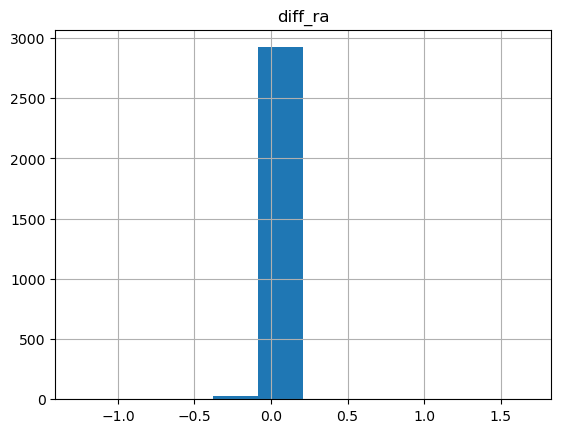

In [135]:
df_merged.hist('diff_ra')

array([[<AxesSubplot:title={'center':'diff_dec'}>]], dtype=object)

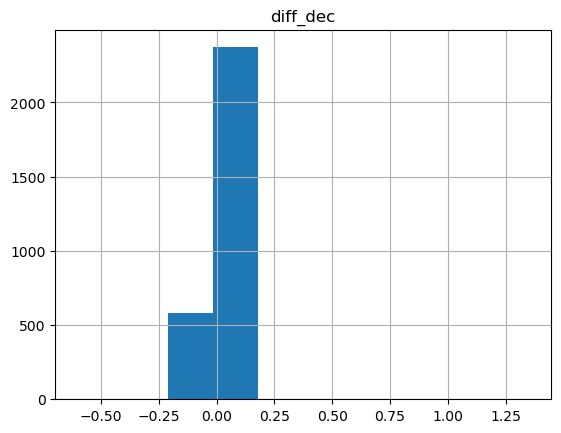

In [136]:
df_merged.hist('diff_dec')

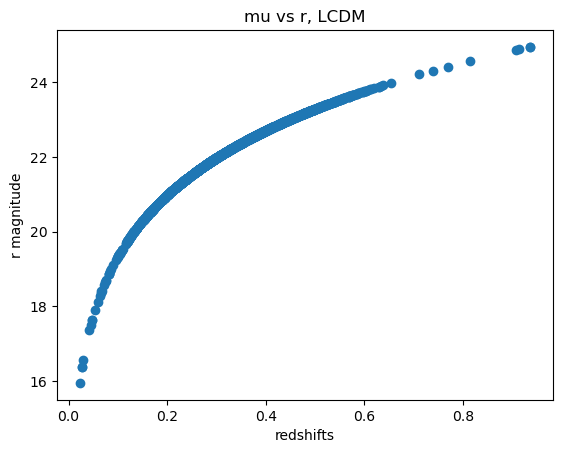

In [137]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=69.32 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)  
R=df_merged['redshift']

import astropy.cosmology.units as cu
d_lcdm={}
d_lcdm=cosmo.luminosity_distance(R)*1000000 #bolometric magnitude ie integrated over all bands

from math import log10
import numpy as np
u_lcdm=[]

for i in d_lcdm:
    v=5*log10(i.to_value()/10)-19   #assumed peak brightness/lumnisoty of all type 1a SNe = -19
    u_lcdm.append(v)

R=df_merged['redshift']
r_mag_max=df_merged['rMagMax']


from matplotlib import pyplot as plt
plt.scatter(R,u_lcdm,label='lcdm')
plt.title('mu vs r, LCDM')
plt.ylabel('r magnitude')
plt.xlabel('redshifts')
plt.show()




0.9370859861373901

In [145]:
a=cosmo.luminosity_distance(3)
a


<Quantity 25666.39002642 Mpc>

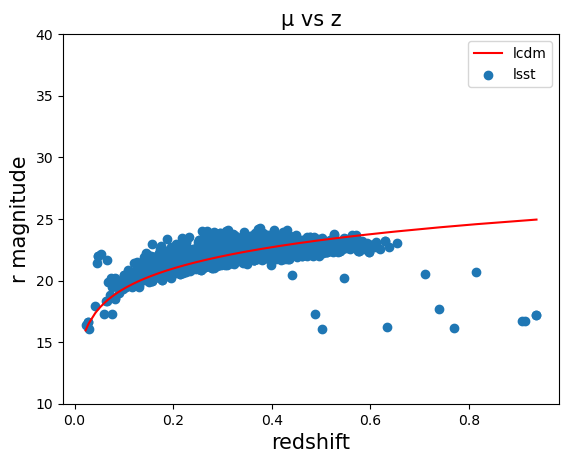

In [141]:
from matplotlib import pyplot as plt
R_=R
u_lcdm_=u_lcdm
plt.plot(np.sort(R_),np.sort(u_lcdm_), label="lcdm", color='r')
plt.scatter(R,r_mag_max,label="lsst")
plt.title('\u03BC vs z', fontsize=15)

plt.ylabel('r magnitude', fontsize=15)
plt.xlabel('redshift', fontsize=15)
plt.ylim(10,40)
plt.legend()
plt.show()

In [115]:
cosmo.z_at_value(10)

AttributeError: 'FlatLambdaCDM' object has no attribute 'z_at_value'